In [1]:
# importing sys
import sys

# adding Folder_2 to the system path
sys.path.insert(0, '/home/jeongeun/test_env/Open-Set-Object-Detection')

In [2]:
import ai2thor
from ai2thor.controller import Controller
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection
from ithor_tools.map2 import single_scenemap
from ithor_tools.astar import astar
import random
from IPython.display import display
from ithor_tools.landmark_utils import gather,vis_panorama,Word_Dict,choose_ladmark
from moviepy.editor import ImageSequenceClip,VideoFileClip
import math

"AI2-THOR Version: " + ai2thor.__version__

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


'AI2-THOR Version: 4.2.0'

In [3]:
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from engine.predictor import DefaultPredictor

from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from engine.optimizer import build_optimizer,build_lr_scheduler

from data.build import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from data.mapper import DatasetMapper
import data.transforms as T
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
from structures.image_list import ImageList
from engine.detection_checkpointer import DetectionCheckpointer
from data.utils import build_augmentation

from model.ssl_score.dino_score import cosine_distance_torch


In [4]:
gridSize=0.05
scene_name = "FloorPlan_Train6_1"
controller = Controller(
    platform = CloudRendering,
    agentMode="locobot",
    visibilityDistance=5.0,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderClassImage = True,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderClassImage = True,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[100]
)

pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
objects = controller.last_event.metadata['objects']

INFO - 2022-06-03 13:37:00,657 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


In [5]:
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


,objectType,objectId,name,position[x],position[y],position[z],rotation[x],rotation[y],rotation[z],distance,...,openness,pickupable,isPickedUp,moveable,mass,salientMaterials,assetId,parentReceptacles,controlledObjects,isMoving
0,Book,Book|+04.81|+01.31|-01.29,Book_21,4.8090,1.3053,-1.2938,0.0071,36.1269,0.1927,3.1391,...,0.0,True,False,False,0.50,[Paper],Book_21,[Dresser|+04.53|+00.00|-01.30],None,False
1,Laptop,Laptop|+09.43|+00.41|-01.44,Laptop_26,9.4268,0.4072,-1.4443,-0.0052,306.3208,359.9017,7.7426,...,1.0,True,False,False,2.30,"[Metal, Plastic, Glass]",Laptop_26,"[Floor|+00.00|+00.00|+00.00, Chair|+09.47|+00....",[],False
2,Cup,Cup|+04.29|+01.31|-01.20,Cup_19,4.2880,1.3052,-1.1978,0.0181,359.9936,0.0314,2.6315,...,0.0,True,False,False,0.40,[Glass],Cup_19,[Dresser|+04.53|+00.00|-01.30],None,False
3,Box,Box|+01.29|+00.51|-02.56,DecorativeBox1,1.2890,0.5050,-2.5640,0.0020,-0.0013,0.0001,1.2517,...,0.0,True,False,False,0.14,[Paper],DecorativeBox1,[SideTable|+01.28|00.00|-02.57],None,False
4,Bottle,Bottle|+09.19|+00.79|-04.57,Bottle_1,9.1890,0.7949,-4.5720,359.9691,359.9926,-0.0021,8.1144,...,0.0,True,False,False,0.20,[Glass],Bottle_1,[TVStand|+08.90|00.00|-04.66],None,False
5,GarbageCan,GarbageCan|+03.68|00.00|-03.52,bin_26,3.6760,-0.0021,-3.5172,359.9688,-0.0002,0.0074,2.9989,...,0.0,False,False,True,0.70,[Plastic],bin_26,[Floor|+00.00|+00.00|+00.00],None,False
6,BasketBall,BasketBall|+05.18|+00.12|-01.22,Basketball_1,5.1847,0.1200,-1.2220,62.3234,309.2912,-0.0007,3.5784,...,0.0,True,False,False,0.60,[Rubber],Basketball_1,[Floor|+00.00|+00.00|+00.00],None,False
7,Apple,Apple|+02.90|+00.53|-02.00,Apple_26,2.8924,0.5268,-2.0229,336.9562,357.5722,11.7557,1.3748,...,0.0,True,False,False,0.20,[Food],Apple_26,"[CoffeeTable|+03.08|00.00|-02.51, Floor|+00.00...",None,True
8,Pillow,Pillow|+06.22|+00.49|-03.41,pillow_26,6.2206,0.4903,-3.4138,0.0025,354.5627,179.9865,4.9458,...,0.0,True,False,False,0.70,[Fabric],pillow_26,"[ArmChair|+06.34|+00.00|-03.39, Floor|+00.00|+...",None,True
9,BaseballBat,BaseballBat|+03.20|+00.52|-02.75,BaseballBat_2,3.2016,0.5157,-2.7460,89.8012,265.8538,274.9442,2.0206,...,0.0,True,False,False,0.90,[Wood],BaseballBat_2,"[CoffeeTable|+03.08|00.00|-02.51, Floor|+00.00...",None,True


In [6]:
landmarks,visible_landmark_name = choose_ladmark(objects)
landmark_cat = [Word_Dict[l] for l in visible_landmark_name]
# query_object = random.choice(objects)
query_object = objects[4] #20
query_object_name = query_object['objectType']

print(query_object_name)

Bottle


In [7]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)

sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1,
                landmark_names=visible_landmark_name,landmarks=landmarks)
sm.plot_landmarks(controller,show=False)
landmark_config = dict(name=visible_landmark_name,color = sm.landmark_colors)

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
0
['Television|+03.70|+01.50|-02.63', 'Drawer|+03.86|+00.26|-02.63', 'Drawer|+03.86|+00.56|-02.63', 'Drawer|+03.86|+00.86|-02.63']
[[{'x': 5.0, 'y': 0.91, 'z': -2.7000000000000006}, 270.0], [{'x': 3.7, 'y': 0.91, 'z': -1.3000000000000007}, 180.0], [{'x': 4.5, 'y': 0.91, 'z': -1.9000000000000004}, 225.0], [{'x': 4.5, 'y': 0.91, 'z': -1.9000000000000004}, 225.0]]
['ArmChair|+06.34|+00.00|-03.39']
[[{'x': 6.300000000000001, 'y': 0.91, 'z': -1.8000000000000007}, 180.0], [{'x': 4.6000000000000005, 'y': 0.91, 'z': -3.4000000000000004}, 90.0], [{'x': 5.2, 'y': 0.91, 'z': -2.4000000000000004}, 135.0]]
['CoffeeTable|+03.08|00.00|-02.51']
[[{'x': 1.8000000000000003, 'y': 0.91, 'z': -2.6000000000000005}, 90.0], [{'x': 3.0000000000000004, 'y': 0.91, 'z': -4.4}, 360.0], [{'x': 2.1, 'y': 0.91, 'z': -1.8000000000000007}, 135.0], [{'x': 2.1, 'y': 0.91, 'z': -1.8000000000000007}, 135.0]]
['SideTable|+01.23|+00.00|-04.67']
[[{'x

In [8]:
landmarks,visible_landmark_name = choose_ladmark(objects)
landmark_cat = [Word_Dict[l] for l in visible_landmark_name]
# query_object = random.choice(objects)
query_object = objects[40] #20
query_object_name = query_object['objectType']

print(query_object_name)


Drawer


0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
0
(418, 713, 4)


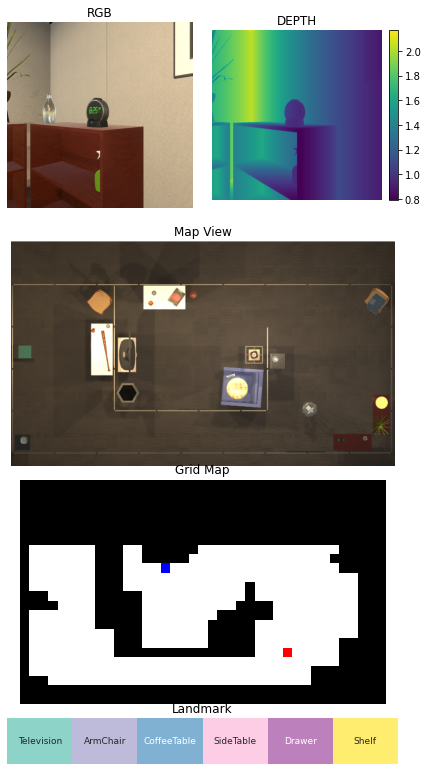

In [9]:
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']
pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.25,landmark_names=visible_landmark_name,landmarks=landmarks)
landmark_config = dict(name=visible_landmark_name,color = sm.landmark_colors)
imshow_grid = sm.plot(controller.last_event.metadata['agent']['position'],query_object['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)


In [10]:
controller.step(action="MoveRight")

<ai2thor.server.Event at 0x7fa1d9a239d0
    .metadata["lastAction"] = MoveRight
    .metadata["lastActionSuccess"] = False
    .metadata["errorMessage"] = "InvalidOperationException: Controller does not support horizontal movement by default. Set AllowHorizontalMovement to true on the Controller.
    .metadata["actionReturn"] = None
>

In [11]:
instance_segmentation = controller.last_event.class_segmentation_frame
query_color = controller.last_event.object_id_to_color[query_object_name]
temp = np.zeros((instance_segmentation.shape[0],instance_segmentation.shape[1]))

# print(controller.last_event.object_id_to_color)
R = np.where(instance_segmentation[:,:,0]==query_color[0])
G = np.where(instance_segmentation[:,:,1]==query_color[1])
B = np.where(instance_segmentation[:,:,2]==query_color[2])
temp[R[0],R[1]] += 1
temp[G[0],G[1]] += 1
temp[B[0],B[1]] += 1
temp = np.where(temp==3)
GT_box = [min(temp[1]),min(temp[0]),max(temp[1]),max(temp[0])]
plt.imshow(instance_segmentation)
plt.axis('off')
plt.show()

ValueError: min() arg is an empty sequence

In [66]:
print(torch.cuda.device_count())
torch.cuda.set_device(0)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('../Open-Set-Object-Detection/config_files/voc.yaml')
cfg.MODEL.SAVE_IDX=1
cfg.MODEL.RPN.USE_MDN=False
cfg.log = False 
cfg.MODEL.ROI_HEADS.USE_MLN = False
cfg.MODEL.ROI_HEADS.AUTO_LABEL = False
cfg.MODEL.ROI_HEADS.AF = 'baseline'
cfg.MODEL.RPN.AUTO_LABEL = False
cfg.MODEL.ROI_BOX_HEAD.USE_FD = False
cfg.MODEL.RPN.AUTO_LABEL_TYPE = 'sum'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 80
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.UNCT = True
cfg.PATH = '../Open-Set-Object-Detection'

# cfg.merge_from_list(args.opts)
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

2
0


In [67]:
device = 'cuda:0'
model = GeneralizedRCNN(cfg,device = device).to(device)
state_dict = torch.load('../Open-Set-Object-Detection/ckpt/{}/{}_{}_17000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location=device)
pretrained_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(pretrained_dict)

predictor = DefaultPredictor(cfg,model)

standard


(418, 713, 4)


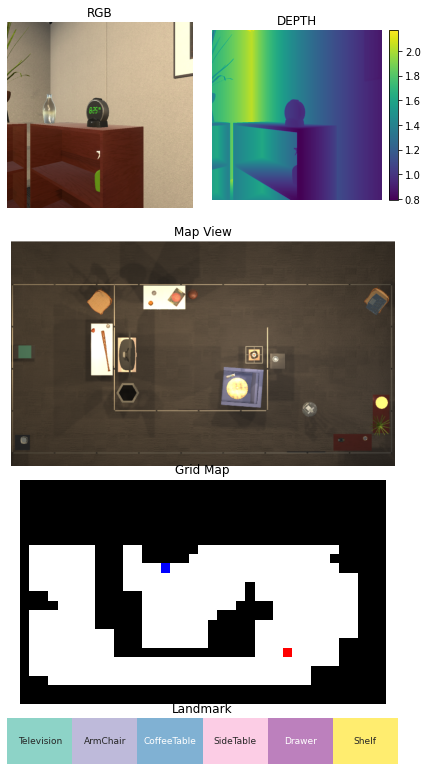

In [68]:
# controller.step(
#     action="RotateRight", degrees = 180
# )
# controller.step(
#     action="MoveRight",moveMagnitude = 1.0
# )
imshow_grid = sm.plot(controller.last_event.metadata['agent']['position'],query_object['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)
img = controller.last_event.cv2img

In [69]:
pred = predictor(img)
pred = pred['instances']._fields

In [70]:
pred_boxes = pred['pred_boxes']
scores = pred['scores']
pred_classes = pred['pred_classes']

index = torch.where(scores>0.3)[0]
pred_boxes = pred_boxes[index]
pred_classes = pred_classes[index]
scores = scores[index]

In [71]:
pred_classes

tensor([69, 23, 44, 60, 21], device='cuda:0')

In [73]:
# VOC_CLASS_NAMES = (
#     "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
#     "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
#     "pottedplant", "sheep", "sofa", "train", "tvmonitor", 'unknown'
# )


COCO_CLASS_NAMES = (
'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
             'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
             'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
             'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
             'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
             'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
             'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
             'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
             'teddy bear', 'hair drier', 'toothbrush'
)

# print(cos_sim)
plt.figure(figsize=(15,15))
demo_image = copy.deepcopy(img)
for bbox,label in zip(pred_boxes,pred_classes):
    if label == 20:
        color = (0,255,0)
    else:
        color = (255,0,0)
    # color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, COCO_CLASS_NAMES[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    # cv2.putText(demo_image, str(sc.item()), 
    #                         (int(bbox[0]), int(bbox[1])),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,2)
plt.title("Predicted - MLN unct")
plt.imshow(demo_image)
plt.axis('off')
plt.show()


### CLIP

In [20]:
import clip
from PIL import Image
from layers.wrappers import cat

In [44]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
new_query_object_name = ''
for i, letter in enumerate(query_object_name):
    if i and letter.isupper():
        new_query_object_name += ' '
    new_query_object_name += letter.lower()
new_query_object_name = 'drawer'
text = clip.tokenize(["a photo of a {}".format(new_query_object_name)]).to(device)
text_features = clip_model.encode_text(text)

In [45]:
"a photo of a {}".format(new_query_object_name)

'a photo of a drawer'

In [46]:
import torchvision.ops as OPS

In [47]:
OPS.box_iou

<function torchvision.ops.boxes.box_iou(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor>

In [48]:
def preprocess(image,bboxs,clip_preprocess,gt_boxes=None):
    res = []
    vis = []
    if gt_boxes !=  None:
        IoU = OPS.box_iou(bboxs,gt_boxes)
    else:
        IoU = 0
    bboxs = np.asarray(bboxs,dtype=np.int16)
    
    for bbox in bboxs:
        y_u = bbox[2]
        y_b = bbox[0]
        x_r = bbox[3]
        x_l = bbox[1]
        crop = image[x_l:x_r,y_b:y_u,:]
        # Make boarder and resize
        y = y_u-y_b
        x = x_r-x_l
        length = max(x, y)

        top = int(length/2 - x/2)
        bottom = int(length/2 - x/2)
        left = int(length/2 - y/2)
        right = int(length/2 - y/2)

        borderType = cv2.BORDER_CONSTANT
        crop = cv2.copyMakeBorder(crop, top, bottom, left, right, borderType)
        crop = cv2.resize(crop,(256,256))
        # convert from BGR to RGB
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        vis.append([crop])
        # convert from openCV2 to PIL
        pil_image=Image.fromarray(crop)
        temp = clip_preprocess(pil_image).unsqueeze(0)
        res.append(temp)
    return torch.cat(res,dim=0),np.concatenate(vis,axis=0),(IoU>0.3)

In [49]:
img = controller.last_event.cv2img
index = (pred_classes==20)
pred_boxes = pred_boxes[index]
pred_classes = pred_classes[index]
patches,vis_patches,gt_label = preprocess(img,pred_boxes.tensor.cpu(),clip_preprocess,None)#torch.LongTensor([GT_box]))
print(patches.shape,vis_patches.shape)

torch.Size([18, 3, 224, 224]) (18, 256, 256, 3)


In [50]:
image_features = clip_model.encode_image(patches.to(device))

In [51]:
dis = torch.matmul(text_features,image_features.T)
dis

tensor([[16.7188, 25.7812, 26.4844, 15.1406, 23.5000, 22.2031, 22.7812, 20.6562,
         21.8281, 21.3438, 22.8438, 16.1875, 20.1406, 22.0156, 25.0938, 17.0469,
         17.4375, 22.1562]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward>)

In [52]:
thres = 25
index = torch.where(dis>thres)[1].cpu()
# print(gt_labe[index])
show_patch = vis_patches[index.numpy()]
candidate_box = pred_boxes[index]

In [53]:
def to_rad(th):
    return th*math.pi / 180

width = 800
height = 800
fov = 90
# camera intrinsics
focal_length = 0.5 * width / math.tan(to_rad(fov/2))
fx, fy, cx, cy = (focal_length, focal_length, width/2, height/2)


In [54]:
import open3d as o3d
# Obtain point cloud
def object_coord(DEPTH,COLOR,agent_pos,agent_rot):
    depth = o3d.geometry.Image(DEPTH)
    color = o3d.geometry.Image(COLOR)
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth,
                                                                depth_scale=1.0,
                                                                depth_trunc=3.0,
                                                                convert_rgb_to_intensity=False)
    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
    # pcd.transform([[0, 1, 0, 0],
    #                 [1, 0, 0, 0],
    #                 [0, 0, -1, 0],
    #                 [0, 0, 0, 1]])
    rot = agent_rot['y']
    pcd.transform([[math.cos(rot), math.sin(rot), 0, agent_pos['x']],
                    [-math.sin(rot), math.cos(rot), 0, agent_pos['z']],
                    [0, 0, 1, 0.9],
                    [0, 0, 0, 1]])
    points = np.asarray(pcd.points)
    points = np.resize(points, (width,height,3))
    new = points[int(center[1]),int(center[0]),:]
    new = dict(x=new[0],y=new[2],z=new[1])
    return new

3


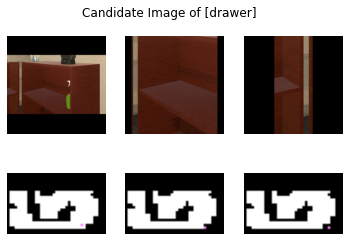

In [55]:
# plt.figure(figsize=(5,5))
plt.suptitle("Candidate Image of [{}]".format(new_query_object_name))
print(len(show_patch))
for e,sp in enumerate(show_patch):
    candidate_box_numpy = candidate_box.tensor.cpu().numpy()[e]
    center = [(candidate_box_numpy[0]+candidate_box_numpy[2])/2,(candidate_box_numpy[1]+candidate_box_numpy[3])/2]
    DEPTH = controller.last_event.depth_frame
    COLOR = controller.last_event.frame.astype(np.uint8)
    new = object_coord(DEPTH,COLOR,controller.last_event.metadata['agent']['position'],controller.last_event.metadata['agent']['rotation'])
    new_grid = sm.xyz2grid(new)
    plt.subplot(2,len(show_patch),e+1)
    plt.imshow(sp)
    plt.axis('off')

    plt.subplot(2,len(show_patch),e+len(show_patch)+1)
    temp = sm.grid_map.copy()
    temp[new_grid[0],new_grid[1],:] = [1,0.5,1]
    temp = np.rot90(temp)
    plt.imshow(temp)
    plt.axis('off')
plt.show()


candidate_depth = DEPTH[int(center[0]),int(center[1])]